In [1]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
DATASET_PATH = Path("/media/artem/A2F4DEB0F4DE85C7/myData/datasets/midv500_compressed")
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [4]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_ocr_t1.data.MidvPackage, 300, course_ocr_t1.data.DataItem)

In [5]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('/media/artem/A2F4DEB0F4DE85C7/myData/datasets/midv500_compressed/19_esp_drvlic/ground_truth/PS/PS19_11.json'),
 PosixPath('/media/artem/A2F4DEB0F4DE85C7/myData/datasets/midv500_compressed/19_esp_drvlic/images/PS/PS19_11.png'))

In [6]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[-139,  444],
       [ 206,  334],
       [ 272,  556],
       [ -76,  673]])

[[-0.30888889  0.555     ]
 [ 0.45777778  0.4175    ]
 [ 0.60444444  0.695     ]
 [-0.16888889  0.84125   ]]


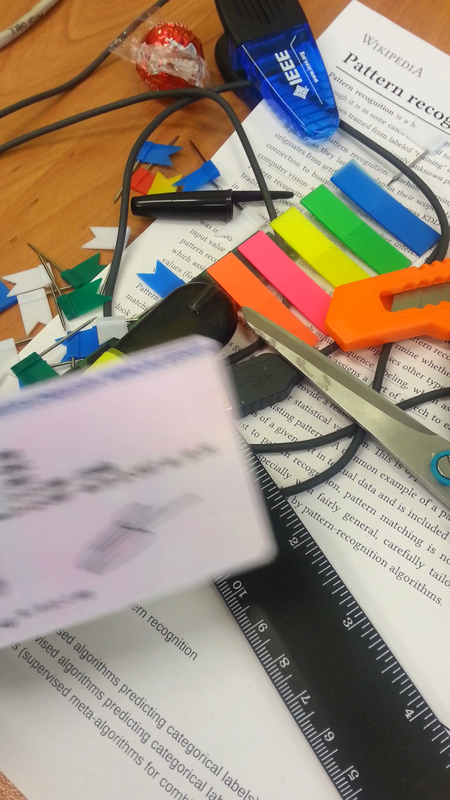

In [7]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

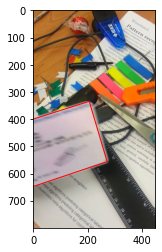

In [8]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [9]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, False)

True


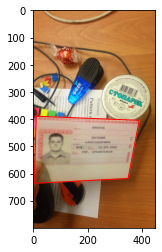

In [10]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [11]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.01it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [12]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.93it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


## Classic CV baseline

### Для работы baseline нужен установленныей OpenCV 

In [13]:
import cv2

In [14]:
import segmentation_models_pytorch
from PIL import Image
import torchvision.transforms as tf
import torch

def get_contours_and_boxes(binarized_map):
    assert binarized_map.dtype == np.uint8
    contours, _ = cv2.findContours(
        binarized_map,
        mode=cv2.RETR_TREE,
        method=cv2.CHAIN_APPROX_SIMPLE)
    
    max_S = -1
    best_area = None

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_S:
            epsilon = 0.1*cv2.arcLength(cnt,True)

            max_S = area
            best_area = cv2.approxPolyDP(cnt,epsilon,True)
    
    best_area = [i[0] for i in best_area]
    
    if len(best_area) != 4:
        best_area = None
        max_S = -1
        for i, c in enumerate(contours):
            rect = cv2.minAreaRect(c)
            w, h = rect[1]
            if w * h > max_S:
                best_area = cv2.boxPoints(rect)
                best_area = np.int0(best_area)
                max_S = w * h
                
        #print(best_area)
    return best_area

m = torch.nn.Sigmoid()

def get_obj(d_binarized_map):
    boxes = get_contours_and_boxes(d_binarized_map)
    
    return boxes

class UnetFilterBaselineCrop():
    """
    """
    def __init__(self):        
        width, height=256, 128 # image width and height
        self.transformImg=tf.Compose([tf.Resize((height,width)),tf.ToTensor(),tf.Normalize( (0.485, 0.456, 0.406), 
                                                                                       (0.229, 0.224, 0.225))])

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Check if there is GPU if not set trainning to CPU (very slow)
        modelPath = "9000.torch"  # Path to trained model

        self.model = segmentation_models_pytorch.UnetPlusPlus(in_channels=3, classes=1)
        self.model.load_state_dict(torch.load(modelPath))
        self.model.to(self.device)
        self.model.eval() # Set to evaluation mode
        
    def mask_filter(self, input_img):     
        height_orgin, widh_orgin, _ = input_img.shape # Get image original size 
        d = 1

        Img = self.transformImg(Image.fromarray(input_img))  # Transform to pytorch
        Img = torch.autograd.Variable(Img, requires_grad=False).to(self.device).unsqueeze(0)

        with torch.no_grad():
            Prd = m(self.model(Img)) # Run net

        Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0]) # Resize to origninal size    
        Prd = Prd.detach().cpu().numpy() > 0.5
        
        return Prd.astype(np.uint8)[0]
    
    def __call__(self, query_image):
        h, w, _ = query_image.shape
        batch_sigmoid_mask = self.mask_filter(query_image)
        detected_objects = get_obj(batch_sigmoid_mask)
        return detected_objects / np.array([[w, h]])


In [15]:
import segmentation_models_pytorch
from PIL import Image
import torchvision.transforms as tf
import torch

class BaselineCrop():
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        0. Найти ключевые точки(КТ) на ref
        1. Найти ключевые точки(КТ) на query
        2. Сопоставить КТ query и ref друг-другу
        3. На основе сопоставления найти гомографию из ref в query
        4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
    """
    def __init__(self, ref_image):
        self.ref_image = ref_image
        
        # 0. Найти ключевые точки(КТ) на ref
        self.ref_kpts, self.ref_fts = self.compute_kps(
            self.ref_image
        )
            
        self.helper = UnetFilterBaselineCrop() # Если не нашел гомографию используй простой детектор на масках
        
    def compute_kps(self, img, response_quantile=0.25):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sift = cv2.SIFT_create()
        kp = sift.detect(gray, None)
        # фильтруем 25% неуверенных точек
        q_val = np.quantile(list(k.response for k in kp), response_quantile)
        kp = [k for k in kp if k.response > q_val]
        
        kp, features = sift.compute(gray, kp)
        return kp, features 
    
    def find_qr_homography(self, kp_q, ft_q, kp_r, ft_r, ratio=0.75):
        # 2. Сопоставить КТ query и ref друг-другу
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(ft_q, ft_r, k=2)
        good = []

        # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
        # Пусть есть лучший матч1 (query-kp, ref-kp)
        # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
        # (т.е. расстояние в пространстве features) маленькое,
        # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
        for m,n in matches:
            if m.distance <  ratio * n.distance:
                good.append([m])
                
        ptsA = np.zeros((len(good), 2), dtype="float")
        ptsB = np.zeros((len(good), 2), dtype="float")

        for (i, mlist) in enumerate(good):
            m = mlist[0]
            ptsA[i] = kp_q[m.queryIdx].pt
            ptsB[i] = kp_r[m.trainIdx].pt
        # 3. На основе сопоставления найти гомографию из ref в query
        
        if len(ptsA) < 4:
            return None, False

        (H, mask) = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC)
        return H, True
              
    def compute_crop(self, ref_img, hmg):
        # 4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
        h, w, _ = ref_img.shape
        h = float(h)
        w = float(w)
        points = [
            [0, 0],
            [w, 0],
            [w, h],
            [0, h],
        ]
        points_crop = []
        for p in points:
            # применяем гомографию к точке, представленной в гомогенных координатах
            vec = hmg @ np.array([p[0], p[1], 1])
            points_crop.append([vec[0]/vec[-1], vec[1]/vec[-1]])
        return np.array(points_crop)
    
    def __call__(self, dp):
        # 1. Найти ключевые точки(КТ) на query
        query_image = np.array(dp.image) 
        
        kpts, fts = self.compute_kps(query_image)
        
        homography, status = self.find_qr_homography(
            kpts, fts, self.ref_kpts, self.ref_fts
        )
        if status == False:
            rel_crop = self.helper(query_image)
            return rel_crop
        
        abs_crop = self.compute_crop(self.ref_image, homography)
        
        h, w, _ = query_image.shape
        rel_crop = abs_crop / np.array([[w, h]])
        
        return rel_crop


In [16]:
bcm = BaselineCrop(np.array(dp.template_item.image))


In [17]:
pred_quad = bcm(dp[0])

In [18]:
w, h = dp[0].image.size
pred_quad, dp[0].quadrangle, dp[0].gt_data['quad'], dp[0].quadrangle * np.array([[w, h]])

(array([[0.0570968 , 0.47387   ],
        [0.73702367, 0.33407344],
        [0.92789712, 0.56707864],
        [0.22790701, 0.72985275]]),
 array([[0.05555556, 0.47375   ],
        [0.73555556, 0.335     ],
        [0.92666667, 0.5675    ],
        [0.22666667, 0.72875   ]]),
 [[25, 379], [331, 268], [417, 454], [102, 583]],
 array([[ 25., 379.],
        [331., 268.],
        [417., 454.],
        [102., 583.]]))

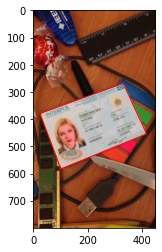

In [19]:
dp[0].show( dp[0].gt_data['quad'] / np.array([[w, h]]))

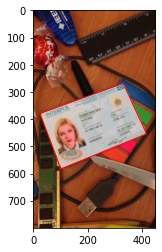

In [20]:
dp[0].show( dp[0].quadrangle )

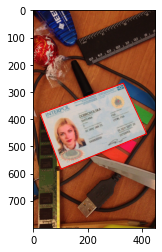

In [21]:
dp[0].show( pred_quad )

In [22]:
results_dict = dict()

i = 0
for dp in tqdm(data_packs):
    
    bcm = BaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = bcm(dp[i])
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 44/50 [04:57<01:23, 13.97s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
'NoneType' object is not iterable
'NoneType' object is not iterable


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 47/50 [06:46<01:25, 28.39s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 49/50 [08:02<00:33, 33.32s/it]

matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:34<00:00, 10.29s/it]


### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [23]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [24]:
dump_results_dict(results_dict, 'pred.json')

In [25]:
from pathlib import Path

In [26]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [27]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9621
